In [1]:
!pip install kaggle
!pip install catboost


    100% |████████████████████████████████| 60.1MB 615kB/s 


In [0]:
!pip install numpy==1.15.0

    100% |████████████████████████████████| 13.9MB 2.4MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as pt
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR,SVR
from sklearn.kernel_ridge import KernelRidge


In [0]:
from google.colab import files
up = files.upload()
for fn in up.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(up[fn])))
  

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
User uploaded file "kaggle.json" with length 65 bytes


In [0]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2560           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10298            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4062           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         36           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2560           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
aerial-c

In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 32.5MB/s]
 96% 233M/242M [00:01<00:00, 189MB/s]
100% 242M/242M [00:01<00:00, 190MB/s]
100% 2.02G/2.03G [00:34<00:00, 38.3MB/s]
100% 2.03G/2.03G [00:35<00:00, 62.0MB/s]


In [0]:
!ls
!unzip train.csv.zip

'kaggle (1).json'   sample_submission.csv   train.csv.zip
 sample_data	    test.zip
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
data = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [0]:
data.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [0]:
train_sample = data['acoustic_data'].values[::100]
train_sample.shape[0]

60000

In [0]:
train_ttf = data['time_to_failure'].values[::100]

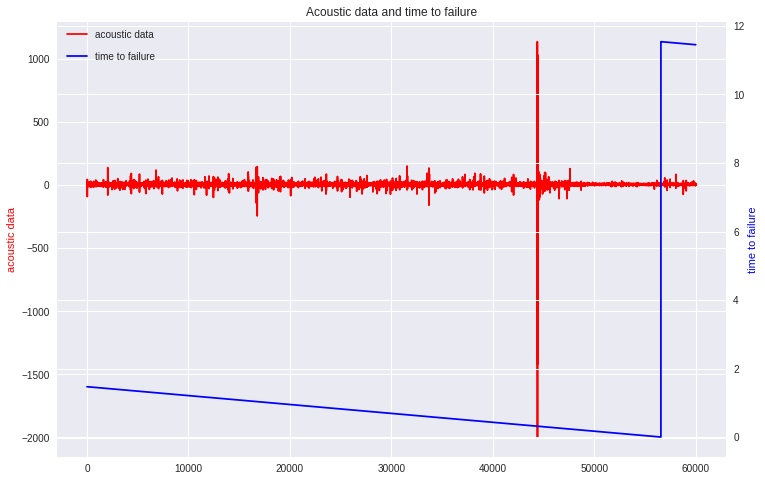

In [0]:
def plot_acc_ttf(train_sample, train_ttf):
    fig, ax1 = pt.subplots(figsize=(12, 8))
    pt.title("Acoustic data and time to failure")
    pt.plot(train_sample, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    pt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    pt.plot(train_ttf, color='b')
    ax2.set_ylabel('time to failure', color='b')
    pt.legend(['time to failure'], loc=(0.01, 0.9))
    pt.grid(True)

plot_acc_ttf(train_sample, train_ttf)

In [0]:
def generate_newfeatures(X):
  newtrain = []
  newtrain.append(X.mean())
  newtrain.append(X.std())
  newtrain.append(X.min())
  newtrain.append(X.kurtosis())
  newtrain.append(X.skew())
  newtrain.append(np.quantile(X,0.01))
  newtrain.append(np.quantile(X,0.10))
  newtrain.append(np.quantile(X,0.50))
  newtrain.append(np.quantile(X,0.90))
  return pd.Series(newtrain) 

  

In [0]:
train_data = pd.read_csv('train.csv', iterator=True, chunksize=250_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
X_train = pd.DataFrame()
y_train = pd.Series()
for df in train_data:
    ch = generate_newfeatures(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [0]:
X_train.describe()
X_train.head()

,0,1,2,3,4,5,6,7,8
0,4.808260,5.969339,-154.0,90.740917,0.326279,-10.0,0.0,5.0,10.0
1,4.870232,6.553343,-115.0,34.236358,0.198095,-14.0,0.0,5.0,10.0
2,4.917848,7.276741,-199.0,87.612526,0.383827,-13.0,0.0,5.0,10.0
3,4.908652,5.596640,-144.0,38.726928,0.074976,-11.0,0.0,5.0,10.0
4,4.577836,6.605473,-156.0,82.782730,-0.243020,-12.0,0.0,5.0,9.0


In [0]:
train_pool = Pool(X_train,y_train)
m = CatBoostRegressor(iterations=10000,loss_function="MAE",boosting_type="Ordered")

In [0]:
m.fit(X_train,y_train)

In [0]:
m.best_score_

{'learn': {'MAE': 1.6184482828033846}}

In [0]:
!ls


 catboost_info	    sample_data		    test.zip    train.csv.zip
'kaggle (1).json'   sample_submission.csv   train.csv


In [0]:
!unzip test.zip


In [0]:
Final = pd.DataFrame()

sub = pd.read_csv('sample_submission.csv')
sub.head()
n = sub.shape[0]
for i in range(0,n):
  t1 =sub.iloc[i][0]
  t2 = t1 +'.csv'
  x1 = pd.read_csv(t2)
  x_Test = pd.DataFrame()
  for df in x1:
      ch = generate_newfeatures(x1['acoustic_data'])
      x_Test = x_Test.append(ch, ignore_index=True)
    
  pre = m.predict(x_Test)
  pd_s = pd.Series([t1,pre[0]])
  Final = Final.append(pd_s,ignore_index=True)


In [0]:
Final.rename(columns={0:'seg_id',1:'time_to_failure'},inplace= True)
Final
Final.to_csv('Submission_F.csv')

In [0]:
from google.colab import files
files.download('Submission_F.csv')